My recommender system is founded on an undirected bipartite graph, with 'users' forming one set of nodes and 'movies' constituting the other. The edges exclusively connect users to movies, signifying recommendations. Essentially, if a user is linked to a movie, it implies a recommendation for that user. 

I've adopted a model utilizing Light Graph Convolutional Networks (LightGCN) to predict new connections. The implementation closely follows a [referenced notebook](https://colab.research.google.com/drive/1VQTBxJuty7aLMepjEYE-d7E9kjo51CA1?usp=sharing#scrollTo=4p_Pj_D7t3Rk), encompassing key components such as an embedding layer, LGConv layers for graph convolutions, and a training process incorporating Bayesian Personalized Ranking (BPR) loss. The model is versatile, allowing for customization in terms of latent dimensions and layer count, and its training is evaluated through metrics like recall and precision on a Top-K basis.

# Install Libs

In [1]:
import torch
import os

os.environ['TORCH'] = torch.__version__
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
# Install torch-scatter, torch-sparse, and pyg-lib from the provided URLs
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/torch-${TORCH}.html

# Install pytorch_geometric from the GitHub repository
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

# Download the MovieLens 100k dataset
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip

# Unzip the downloaded dataset
!unzip ml-100k.zip

Looking in links: https://data.pyg.org/whl/torch-2.0.0.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3757545 sha256=61faad49b693fd521fe0f8c60a21f0763f982914b6b2e488d9f43fbaf67e1295
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-2.0.0.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 5.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=2609253 sha256=c1d23a566fbd6edf1dc265f2c9df20832959c00638d3cdf3266a9bdbc61567d7
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built torch-spar

# Seeding

Manual seeding for reproducibility

In [3]:
import random
import numpy as np

RANDOM = 123

random.seed(RANDOM)
torch.manual_seed(RANDOM)
np.random.seed(RANDOM)

# Data preparation

## Reading

In [4]:
import pandas as pd

columns_name = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv("/kaggle/working/ml-100k/u.data", sep="\t", names=columns_name)
df

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [5]:
genres = pd.read_csv('/kaggle/working/ml-100k/u.genre', sep='|', header=None)
ind2genre = genres[0].tolist()
genre2ind = {g: i for i, g in enumerate(ind2genre)}

items = pd.read_csv('/kaggle/working/ml-100k/u.item', sep='|', encoding='latin-1',
                   names=['movieId', 'movieName', 'releaseDate', 'videoDate', 'url'] + ind2genre)
items

,movieId,movieName,releaseDate,videoDate,url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Preprocessing
We only want to use high ratings as interactions in order to predict which movies a user will enjoy watching next.

In [6]:
# Filter the DataFrame to include only rows where the rating is greater than or equal to 3
df = df[df['rating'] >= 3]
df

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
5,298,474,4,884182806
7,253,465,5,891628467
8,305,451,3,886324817
...,...,...,...,...
99992,721,262,3,877137285
99994,378,78,3,880056976
99995,880,476,3,880175444
99996,716,204,5,879795543


In [7]:
from sklearn.model_selection import train_test_split

# Specify the test size and random state for reproducibility
test_size = 0.2
random_state = RANDOM

train, test = train_test_split(df.values, test_size=test_size, random_state=random_state)

# Create train and test DataFrames with the same column names
train_df, test_df = pd.DataFrame(train, columns=df.columns), pd.DataFrame(test, columns=df.columns)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders for user and item IDs
le_user, le_item = LabelEncoder(), LabelEncoder()

# Encode user and item IDs in the training set and create new columns for the indices
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

# Get unique user and item IDs in the training set
train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

print("Number of unique user IDs in training set:", len(train_user_ids))
print("Number of unique item IDs in training set:", len(train_item_ids))

# Filter the test set to include only users and items present in the training set
test_df = test_df[
    (test_df['user_id'].isin(train_user_ids)) & (test_df['item_id'].isin(train_item_ids))
]

test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

# Get the number of unique user and item indices in the training set
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()

print("Number of Unique Users: ", n_users)
print("Number of Unique Items: ", n_items)

Number of unique user IDs in training set: 943
Number of unique item IDs in training set: 1539
Number of Unique Users:  943
Number of Unique Items:  1539


In [9]:
def data_loader(data, batch_size, n_usr, n_itm):
    """
    Custom data loader for generating positive and negative samples for training.

    Args:
        data (pd.DataFrame): Training data containing user-item interactions.
        batch_size (int): Number of samples to generate in each batch.
        n_usr (int): Number of unique users.
        n_itm (int): Number of unique items.

    Returns:
        Tuple of three PyTorch LongTensor: (user_ids, positive_item_ids, negative_item_ids)
    """

    def sample_neg(x):
        """
        Sample a negative item not interacted by the user.
        """
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    # Group by user and get a list of interacted items for each user
    interacted_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    # Sample users for the batch
    if n_usr < batch_size:
        users = [random.choice(range(n_usr)) for _ in range(batch_size)]
    else:
        users = random.sample(range(n_usr), batch_size)
    users.sort()

    users_df = pd.DataFrame(users, columns=['user_id_idx'])

    # Merge with interacted items DataFrame to get positive items
    interacted_items_df = pd.merge(interacted_items_df, users_df, how='right', left_on='user_id_idx', right_on='user_id_idx')

    pos_items = interacted_items_df['item_id_idx'].apply(lambda x: random.choice(x)).values
    # Generate negative items for each user in the batch
    neg_items = interacted_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(users).to(device),
        torch.LongTensor(pos_items).to(device) + n_usr,
        torch.LongTensor(neg_items).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_items)

(tensor([ 39,  53,  89, 110, 272, 274, 340, 348, 388, 417, 549, 575, 787, 858,
         895, 922], device='cuda:0'),
 tensor([1242, 1215, 1380, 1243, 1228, 1037, 1811, 1395, 1353, 1246, 1123, 1614,
         1135, 2234, 1372, 1412], device='cuda:0'),
 tensor([ 956, 1589, 2442, 1861, 1151, 1032, 1132, 2309, 1234, 1201,  986, 1540,
         1824, 2117, 1919, 1486], device='cuda:0'))

In [10]:
import torch

# Convert user and item indices to PyTorch LongTensor
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

# Create edge index tensor for training
train_edge_index = torch.stack((
    torch.cat([u_t, i_t]),
    torch.cat([i_t, u_t])
)).to(device)

train_edge_index

tensor([[  81,  706,  592,  ..., 1012, 1643, 1386],
        [1298, 1139, 1748,  ...,  195,  522,  333]], device='cuda:0')

# Model

In [11]:
from torch_geometric.nn import LGConv
import torch.nn as nn

class RecSysGNN(nn.Module):
    def __init__(
        self,
        latent_dim,
        num_layers,
        num_users,
        num_items,
    ):
        super(RecSysGNN, self).__init__()

        # Combine user and item embeddings into a single embedding matrix
        self.embedding = nn.Embedding(num_users + num_items, latent_dim)

        # Use LGConv for the graph convolutional layers
        self.convs = nn.ModuleList([LGConv(latent_dim) for _ in range(num_layers)])

        self.init_parameters()

    def init_parameters(self):
        nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, edge_index):
        emb0 = self.embedding.weight

        # Store intermediate embeddings in a list
        embs = [emb0]

        # Apply graph convolutional layers
        emb = emb0
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        # Aggregate intermediate embeddings by taking their mean
        out = torch.mean(torch.stack(embs, dim=0), dim=0)

        return emb0, out

    def encode_minibatch(self, users, pos_items, neg_items, edge_index):
        # Call the forward method to obtain embeddings
        emb0, out = self(edge_index)

        # Extract embeddings for users, positive items, and negative items
        user_emb, pos_item_emb, neg_item_emb = out[users], out[pos_items], out[neg_items]

        # Extract initial embeddings for users, positive items, and negative items
        user_emb0, pos_item_emb0, neg_item_emb0 = emb0[users], emb0[pos_items], emb0[neg_items]

        return user_emb, pos_item_emb, neg_item_emb, user_emb0, pos_item_emb0, neg_item_emb0

# Loss

In [12]:
import torch.nn.functional as F

def compute_bpr_loss(users_emb, pos_emb, neg_emb):
    """
    Compute BPR loss.

    Args:
        users_emb (torch.Tensor): Embeddings for users.
        pos_emb (torch.Tensor): Embeddings for positive items.
        neg_emb (torch.Tensor): Embeddings for negative items.

    Returns:
        BPR loss.
    """
    # Compute BPR loss
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss

In [13]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    # Get unique user IDs from the test set
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    # Compute the score of all user-item pairs
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts, 0, 1))

    # Create a dense tensor of all user-item interactions
    i = torch.stack((
        torch.LongTensor(train_data['user_id_idx'].values),
        torch.LongTensor(train_data['item_id_idx'].values)
    ))
    v = torch.ones((len(train_data)), dtype=torch.float64)
    interactions_t = torch.sparse_coo_tensor(i, v, (n_users, n_items), device=device).to_dense()

    # Mask out training user-item interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # Compute top scoring items for each user
    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),
                                             columns=['top_indx_' + str(x + 1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[
        ['top_indx_' + str(x + 1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID', 'top_rlvnt_itm']]

    # Measure overlap between recommended (top-scoring) and held-out user-item interactions
    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    metrics_df = pd.merge(test_interacted_items, topk_relevance_indices_df, how='left', left_on='user_id_idx',
                          right_on=['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx,
                                                                              metrics_df.top_rlvnt_itm)]

    # Compute recall and precision
    metrics_df['recall'] = metrics_df.apply(lambda x: len(x['intrsctn_itm']) / len(x['item_id_idx']), axis=1)
    metrics_df['precision'] = metrics_df.apply(lambda x: len(x['intrsctn_itm']) / K, axis=1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean()


def get_top_k_movies(user_id, user_Embed_wts, item_Embed_wts, K):
    """
    Get the top K movie indexes for a given user.

    Args:
        user_id (int): The user ID for which to get top K movies.
        user_Embed_wts (torch.Tensor): Embeddings for users.
        item_Embed_wts (torch.Tensor): Embeddings for items.
        K (int): Number of top movies to retrieve.

    Returns:
        list: Top K movie indexes for the given user.
    """
    # Compute the score of all user-item pairs
    user_scores = user_Embed_wts[user_id] @ item_Embed_wts.t()

    # Get the top K movie indexes
    topk_movie_indexes = torch.topk(user_scores, K).indices.cpu().numpy().tolist()

    return topk_movie_indexes

def get_metrics_for_user(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, user_id, K):
    """
    Compute recall and precision metrics for a given user.

    Args:
        user_Embed_wts (torch.Tensor): Embeddings for users.
        item_Embed_wts (torch.Tensor): Embeddings for items.
        n_users (int): Number of unique users.
        n_items (int): Number of unique items.
        train_data (pd.DataFrame): Training data.
        test_data (pd.DataFrame): Testing data.
        user_id (int): User ID for which to compute metrics.
        K (int): Number of top movies to consider for metrics.

    Returns:
        Tuple: Recall and Precision metrics.
    """
    # Get unique user IDs from the test set
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    # Compute the score of all user-item pairs
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts, 0, 1))

    # Create a dense tensor of all user-item interactions
    i = torch.stack((
        torch.LongTensor(train_data['user_id_idx'].values),
        torch.LongTensor(train_data['item_id_idx'].values)
    ))
    v = torch.ones((len(train_data)), dtype=torch.float64)
    interactions_t = torch.sparse_coo_tensor(i, v, (n_users, n_items), device=user_Embed_wts.device).to_dense()

    # Mask out training user-item interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # Get the top K movies for the specified user
    top_k_movies = get_top_k_movies(user_id, user_Embed_wts, item_Embed_wts, K)

    # Measure overlap between recommended (top-scoring) and held-out user-item interactions
    test_user_data = test_data[test_data['user_id_idx'] == user_id]
    test_interacted_items = set(test_user_data['item_id_idx'].values)
    intersection_items = set(top_k_movies) & test_interacted_items

    # Compute recall and precision
    recall = len(intersection_items) / len(test_interacted_items) if len(test_interacted_items) > 0 else 0.0
    precision = len(intersection_items) / K

    return recall, precision

def get_movie_names_for_user(user_id, user_Embed_wts, item_Embed_wts, items, genres, K):
    """
    Get the names of the top K recommended movies for a given user.

    Args:
        user_id (int): User ID for which to get movie names.
        user_Embed_wts (torch.Tensor): Embeddings for users.
        item_Embed_wts (torch.Tensor): Embeddings for items.
        items (pd.DataFrame): DataFrame containing movie information.
        genres (pd.DataFrame): DataFrame containing genre information.
        K (int): Number of top movies to retrieve.

    Returns:
        list: Names of the top K recommended movies for the given user.
    """
    # Get the top K movie indexes for the user
    top_k_movies = get_top_k_movies(user_id, user_Embed_wts, item_Embed_wts, K)

    # Get movie names corresponding to the top K movie indexes
    top_k_movie_names = items.loc[top_k_movies, 'movieName'].tolist()

    return top_k_movie_names

# Train

In [34]:
latent_dim = 64
n_layers = 2

EPOCHS = 150
BATCH_SIZE = 1024
K = 20

In [35]:
import torch.optim as optim
from tqdm.autonotebook import tqdm
import numpy as np

def train_and_eval(model, optimizer, train_df, test_df, train_edge_index, n_users, n_items, K, epochs=EPOCHS, batch_size=BATCH_SIZE):
    """
    Train and evaluate a recommender system model.

    Args:
        model (RecSysGNN): The recommender system model.
        optimizer (torch.optim.Optimizer): The optimizer for training.
        train_df (pd.DataFrame): The training data.
        test_df (pd.DataFrame): The testing data.
        train_edge_index (torch.Tensor): The training edge index tensor.
        n_users (int): Number of unique users.
        n_items (int): Number of unique items.
        K (int): Top K items for evaluation metrics.
        epochs (int): Number of training epochs (default: EPOCHS).
        batch_size (int): Batch size for training (default: BATCH_SIZE).
        decay (float): Decay factor for regularization loss (default: DECAY).

    Returns:
        Tuple of lists: (loss_list_epoch, bpr_loss_list_epoch, reg_loss_list_epoch, recall_list, precision_list).
    """
    bpr_loss_list_epoch = []
    recall_list = []
    precision_list = []

    for epoch in tqdm(range(epochs)):
        n_batch = int(len(train_df) / batch_size)

        bpr_loss_list = []

        model.train()
        for batch_idx in range(n_batch):
            optimizer.zero_grad()

            users, pos_items, neg_items = data_loader(train_df, batch_size, n_users, n_items)
            users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = model.encode_minibatch(users, pos_items,
                                                                                              neg_items, train_edge_index)

            bpr_loss = compute_bpr_loss(users_emb, pos_emb, neg_emb)

            bpr_loss.backward()
            optimizer.step()

            bpr_loss_list.append(bpr_loss.item())

        model.eval()
        with torch.no_grad():
            _, out = model(train_edge_index)
            final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
            test_topK_recall, test_topK_precision = get_metrics(
                final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
            )

        bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list), 4))

        recall_list.append(round(test_topK_recall, 4))
        precision_list.append(round(test_topK_precision, 4))

    return (
        bpr_loss_list_epoch,
        recall_list,
        precision_list
    )

### Train and eval LightGCN

In [36]:
model = RecSysGNN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=n_users,
    num_items=n_items
).to(device)

optimizer = torch.optim.Adam(model.parameters())

In [37]:
bprs, recalls, precisions = train_and_eval(model, optimizer, train_df, test_df, train_edge_index, n_users, n_items, K)

  0%|          | 0/150 [00:00<?, ?it/s]

# Evaluation

In [38]:
epoch_list = [(i+1) for i in range(EPOCHS)]

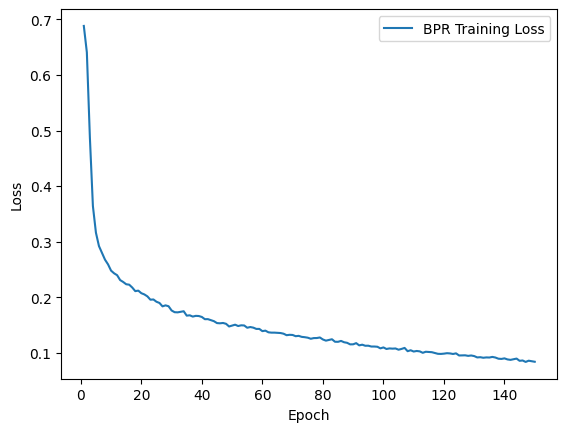

In [39]:
import matplotlib.pyplot as plt


plt.plot(epoch_list, bprs, label='BPR Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

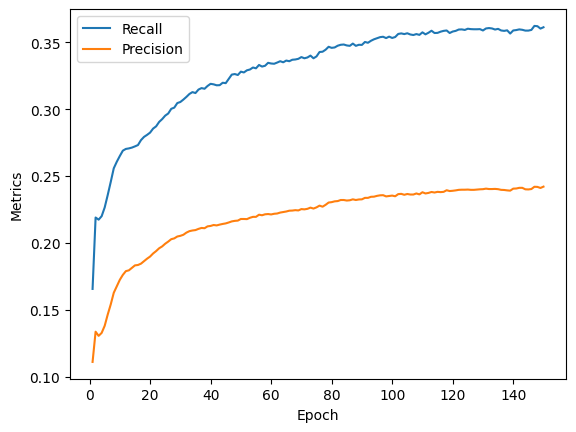

In [40]:
plt.plot(epoch_list, recalls, label='Recall')
plt.plot(epoch_list, precisions, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [42]:
max(precisions), max(recalls)

(0.2421, 0.3623)

In [71]:
user_id_to_evaluate = 4
K_to_evaluate = 10

with torch.no_grad():
    _, out = model(train_edge_index)
    user_Embed_wts, item_Embed_wts = torch.split(out, (n_users, n_items))
    # Call the function with your actual user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, and test_data
    recall, precision = get_metrics_for_user(user_Embed_wts, item_Embed_wts, n_users, n_items, train_df, test_df, user_id_to_evaluate, K_to_evaluate)

    print(f'Recall@{K_to_evaluate}: {recall:.4f}')
    print(f'Precision@{K_to_evaluate}: {precision:.4f}')
    
    print()
    
    recommended_movies = get_movie_names_for_user(user_id_to_evaluate, user_Embed_wts, item_Embed_wts, items, ind2genre, K_to_evaluate)

    # Print the recommended movies
    print(f"Top {K_to_evaluate} movies recommended for User {user_id_to_evaluate}:")
    for i, movie_name in enumerate(recommended_movies, 1):
        print(f"{i}. {movie_name}")

Recall@10: 0.0833
Precision@10: 0.2000

Top 10 movies recommended for User 4:
1. Star Trek: The Wrath of Khan (1982)
2. Star Trek VI: The Undiscovered Country (1991)
3. Stargate (1994)
4. Duck Soup (1933)
5. Return of the Jedi (1983)
6. Star Trek IV: The Voyage Home (1986)
7. Star Trek: First Contact (1996)
8. Monty Python's Life of Brian (1979)
9. Ghost (1990)
10. Monty Python and the Holy Grail (1974)


In [74]:
for i in test_df.groupby('user_id_idx')['item_id'].apply(list).iloc[user_id_to_evaluate]:
    print(items.iloc[i]['movieName'])

Cinderella (1950)
Flintstones, The (1994)
William Shakespeare's Romeo and Juliet (1996)
Hot Shots! Part Deux (1993)
Forbidden Planet (1956)
Four Rooms (1995)
Star Trek III: The Search for Spock (1984)
So I Married an Axe Murderer (1993)
Bio-Dome (1996)
Terminator 2: Judgment Day (1991)
Aristocats, The (1970)
Mary Poppins (1964)
Amityville 1992: It's About Time (1992)
Jaws (1975)
American Werewolf in London, An (1981)
Duck Soup (1933)
Cinema Paradiso (1988)
Heavy Metal (1981)
Diabolique (1996)
Ghost (1990)
Indiana Jones and the Last Crusade (1989)
Princess Bride, The (1987)
GoodFellas (1990)
Carrie (1976)


In [73]:
for i in train_df.groupby('user_id_idx')['item_id'].apply(list).iloc[user_id_to_evaluate]:
    print(items.iloc[i - 1]['movieName'])

Muppet Treasure Island (1996)
Birdcage, The (1996)
Aladdin and the King of Thieves (1996)
Grand Day Out, A (1992)
Star Trek IV: The Voyage Home (1986)
Duck Soup (1933)
Carrie (1976)
Fifth Element, The (1997)
Last Action Hero (1993)
unknown
Sound of Music, The (1965)
Age of Innocence, The (1993)
To Wong Foo, Thanks for Everything! Julie Newmar (1995)
Fish Called Wanda, A (1988)
Three Musketeers, The (1993)
Harold and Maude (1971)
Fear of a Black Hat (1993)
Sneakers (1992)
Die Hard 2 (1990)
Indiana Jones and the Last Crusade (1989)
Birds, The (1963)
Silence of the Lambs, The (1991)
So I Married an Axe Murderer (1993)
Fantasia (1940)
Close Shave, A (1995)
Forbidden Planet (1956)
Showgirls (1995)
Rumble in the Bronx (1995)
Star Trek VI: The Undiscovered Country (1991)
Toy Story (1995)
Love Bug, The (1969)
Nightmare on Elm Street, A (1984)
Aliens (1986)
Sudden Death (1995)
Monty Python and the Holy Grail (1974)
Transformers: The Movie, The (1986)
Sting, The (1973)
Mars Attacks! (1996)
Retur

In [67]:
torch.save(model.state_dict(), 'model.pth')